# Chunking tutorial

The end goal when using the ACCESS-NRI catalog is to open some data as an xarray dataset(s) for analysis. The Intake-ESM datastore methods `to_dask` and `to_dataset_dict` return xarray datasets backed by dask arrays.

```{note}
   If you don’t know what a dask array is, check out the dask array documentation [here](https://docs.dask.org/en/stable/array.html)
```

Intake-ESM uses `xarray.open_dataset` to open datasets. By default, the argument `chunks={}` is used, which gives the following chunking:
- xarray < v2023.09.0: a single chunk per file
- xarray >= v2023.09.0: the "preferred" chunking for the file type being opened, which for NetCDF4 is the chunking on disk.

In some cases, these defaults may produce poor chunk sizes for the subsequent analysis.

In this tutorial, we briefly demonstrate how one might go about choosing and setting the dask chunk size when opening some data using the ACCESS-NRI catalog. This tutorial may be relevant to users wanting to open and work with some of the particularly large data products in the catalog, where careful consideration of chunking can make the difference between an analysis running or crashing. You can download the Jupyter notebook rendered below from [here](https://github.com/ACCESS-NRI/access-nri-intake-catalog/blob/main/docs/usage/chunking.ipynb) and run it yourself in an NCI ARE instance.

In [1]:
import warnings

warnings.filterwarnings("ignore") # Suppress warnings for these docs

## General advice

Before diving into the tutorial, it's worth touching on a few important considerations when choosing dask chunk sizes:

- Dask will distribute work (i.e. your analysis) on different chunks to different workers. If chunks are too small, the overhead burden of coordinating all the chunks starts to become significant. If chunk sizes are too large, your workers are likely to run out of memory. For typical dask cluster configurations, a good rule-of-thumb is to aim for chunk sizes between 100 MB and 1 GB, or about 10-20% of the memory available to each worker.

- It's important to consider the analysis you're wanting to do when choosing chunk sizes. In general, you want to avoid dask having to pass data between workers. Think about how you can chunk your data so that each worker can do your analysis more-or-less independently of other workers. For example, if you're only doing operations in time, it may make sense to chunk your data along the spatial dimensions.

- The chunking of the files on disk is an important factor. The majority of the files that comprise the data products in the ACCESS-NRI catalog are [chunked NetCDF4 files](https://www.unidata.ucar.edu/software/netcdf/workshops/2011/nc4chunking/). Dask chunks should be multiples of the NetCDF chunks to avoid dask having to read the same data repeatedly, which can be expensive.

Check out [this link](https://blog.dask.org/2021/11/02/choosing-dask-chunk-sizes) for a more detailed breakdown of these considerations and more.

## Open some difficult data with default chunking

In this example, we'll be using the ACCESS-OM2 `01deg_jra55v13_ryf9091` product. This was chosen because it includes data that is particularly ill suited to the default chunking strategy used by Intake-ESM. We can load the ACCESS-NRI catalog and open the Intake-ESM datastore for this product directly.

In [2]:
import intake

catalog = intake.cat.access_nri

In [3]:
esm_datastore = catalog["01deg_jra55v13_ryf9091"]

esm_datastore

,unique
path,11947
realm,2
variable,178
frequency,5
start_date,3361
end_date,3361
variable_long_name,181
variable_standard_name,36
variable_cell_methods,3
variable_units,50


Let's find and open a dataset containing the variable "temp" at daily frequency. We'll first start a local dask cluster to use to distribute our work.

In [4]:
from distributed import Client

client = Client(threads_per_worker=1)
client.dashboard_link

'/proxy/8787/status'

```{hint}
   If you're actually running this tutorial, it is very helpful to monitor the dask dashboard when working with dask. Click on the dask icon on the far left of the screen (three orange and red squares) and enter the text output by the previous cell in the search bar. Each of the different orange panels is a different dashboard that you can use to monitor what dask is doing. If you don't know which to choose, the "Task Stream", "Progress", "CPU" and "Workers Memory" diagnostics are a good start. Click on these, and drag the windows to where ever you want them in your JupyterLab.
```

In [5]:
esm_datastore_filtered = esm_datastore.search(
    variable=["temp", "average_DT"], frequency="1day", require_all_on="path"
)

ds = esm_datastore_filtered.to_dask()

As mentioned above, the default dask chunking when opening data from our datastore with xarray < v2023.09.0 is to have one chunk per file, which in this case results in chunks that are 250 GB each (see the "Chunk" column in the DataArray summary below)!

```{note}
   If you ran this notebook with xarray >= v2023.09.0, you will see chunk sizes of 3.2 MB. This is because the behaviour of the default chunking argument used by Intake-ESM changed with xarray v2023.09.0. 3.2 MB is definitely better than 250 GB, but its' still quite far from our rule-of-thumb of 100 MB - 1 GB, so what follows is still relevant.
```

In [5]:
ds["temp"]

<xarray.DataArray 'temp' (time: 3832, st_ocean: 75, yt_ocean: 2700,
                          xt_ocean: 3600)>
dask.array<concatenate, shape=(3832, 75, 2700, 3600), dtype=float32, chunksize=(92, 75, 2700, 3600), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 -81.11 -81.07 -81.02 ... 89.89 89.94 89.98
  * st_ocean  (st_ocean) float64 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03
  * time      (time) object 1966-01-01 12:00:00 ... 2179-12-31 12:00:00
Attributes:
    long_name:      Conservative temperature
    valid_range:    [-10. 500.]
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    coordinates:    geolon_t geolat_t
    standard_name:  sea_water_conservative_temperature

When we try to do any analysis with these data, dask will try to load chunks onto workers in our cluster and these workers will quickly run out of memory. E.g., below we try to compute the standard deviation in time at the surface. Running this cell will bring down our cluster.

In [ ]:
surface_std = ds["temp"].isel(st_ocean=0).std("time").compute()

## Choosing better dask chunk sizes

To choose our chunk sizes, we want to take into account the chunk layout of the files we're reading. In this case, as for the vast majority of the products currently in the ACCESS-NRI catalog, the files are NetCDF4 format. We can see how they are chunked by looking at the output of `ncdump -hs <file>` run on one of the files that make up the dataset, or by looking at the `encoding` attribute of the variable we're interested in in our xarray dataset

```{note}
If you ran this notebook with xarray >= v2023.09.0, the default chunking returned by Intake-ESM is the file chunking so there's no need to use `ncdump` or look at the `encoding` attribute - you can just read it from the "Chunk" column in the DataArray summary above.
```

In [6]:
ds["temp"].encoding

{'zlib': True,
 'szip': False,
 'zstd': False,
 'bzip2': False,
 'blosc': False,
 'shuffle': True,
 'complevel': 5,
 'fletcher32': False,
 'contiguous': False,
 'chunksizes': (1, 7, 300, 400),
 'source': '/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091/output260/ocean/ocean_daily_3d_temp.nc',
 'original_shape': (90, 75, 2700, 3600),
 'dtype': dtype('float32'),
 'missing_value': -1e+20,
 '_FillValue': -1e+20}

You can see that the NetCDF4 chunk sizes are 1, 7, 300 and 400 for the "time", "st_ocean", "yt_ocean" and "xt_ocean" dimensions, respectively.

Choosing the optimal dask chunk sizes for a given analysis can sometimes be a bit of an iterative process. As a first try we'll use a chunk layout that provides ~300 MB chunk sizes, doesn't divide the chunking on disk, and chunks along the spatial dimensions, since our "analysis" here is to take the standard deviation in time. We can specify the chunking we want when we open the dataset from our Intake-ESM datastore using the `xarray_open_kwargs` argument. This can be passed to either `to_dataset_dict` or `to_dask` depending on how many datasets you are trying to open. For more details on specifying chunk sizes see the xarray documentation on [Parallel computing with Dask](https://xarray.pydata.org/en/v2023.09.0/user-guide/dask.html).

In [7]:
xarray_open_kwargs = {"chunks": {"time": -1, "st_ocean": 7, "xt_ocean": 400, "yt_ocean": 300}}

ds = esm_datastore_filtered.to_dask(xarray_open_kwargs=xarray_open_kwargs)

In [8]:
ds["temp"]

<xarray.DataArray 'temp' (time: 3832, st_ocean: 75, yt_ocean: 2700,
                          xt_ocean: 3600)>
dask.array<concatenate, shape=(3832, 75, 2700, 3600), dtype=float32, chunksize=(92, 7, 300, 400), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 -81.11 -81.07 -81.02 ... 89.89 89.94 89.98
  * st_ocean  (st_ocean) float64 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03
  * time      (time) object 1966-01-01 12:00:00 ... 2179-12-31 12:00:00
Attributes:
    long_name:      Conservative temperature
    valid_range:    [-10. 500.]
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    coordinates:    geolon_t geolat_t
    standard_name:  sea_water_conservative_temperature

With this chunking, memory is now managed effectively by our dask workers and our computation now finishes in a timely manner.

In [ ]:
surface_std = ds["temp"].isel(st_ocean=0).std("time").compute()

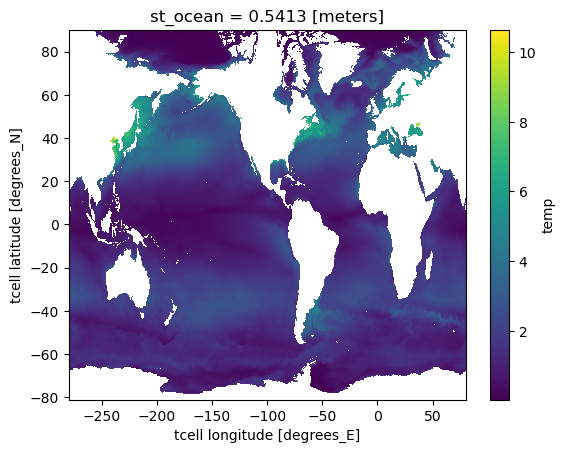

In [11]:
surface_std.plot()

In [10]:
client.close()